In [181]:
""" import useful functions """

# Generic
#import pandas as pd
import numpy as np
import scipy
import sys
from itertools import islice, cycle
import math
import os
import sys
from scipy.integrate import odeint
from joblib import Parallel, delayed
import itertools
from importlib import reload
from functools import lru_cache

# cosmology
import pyccl as ccl
from astropy.io import fits
import yaml
import sacc
import time

# covariance - Charlie's version of TJPCov
MODULE_PATH = "/home/c2042999/TJPCov/tjpcov/__init__.py"
MODULE_NAME = "tjpcov"
import importlib
spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module 
spec.loader.exec_module(module)
from tjpcov.covariance_calculator import CovarianceCalculator

# Generate data sets
from sklearn.datasets import make_blobs

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# SRD Binning
import srd_redshift_distributions as srd
import binning

# Data Visualization
import matplotlib.pyplot as plt
#import seaborn as sns

# MCMC
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner
from IPython.display import display, Math
from multiprocessing import Pool

# nDGP NL and lin Pk
from nDGPemu import BoostPredictor

# MGCAMB
MODULE_PATH = "/home/c2042999/MGCAMB/camb/__init__.py"
MODULE_NAME = "MGCAMB"
import importlib
spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module 
spec.loader.exec_module(module)
from MGCAMB import camb

# f(R) emu (FORGE)
os.chdir("/home/c2042999/forge_emulator")
from FORGE_emulator import FORGE
os.chdir("/home/c2042999/PCA_project")


In [182]:
"""Initialize some things (e.g. emulators and MGCAMB)"""
# Load the nDGP emulator
model_nDGP = BoostPredictor()

# Initialize MGCAMB
pars = camb.CAMBparams()


Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [183]:
#reload(camb)

In [184]:
"""For tests"""

cosmo_testing = ccl.Cosmology(Omega_c = 0.281 - 0.046,
                           Omega_b =  0.046,
                           h = 0.697,
                           n_s = 0.971,
                           A_s = 2.01e-9)
cosmo_universe = cosmo_testing

In [185]:
## Setup FORGE emu

forge_emulator = FORGE()

# 2. Define functions to get various (P(k))

The power spectrum in $\Lambda$CDM and nDGP is the same in the early universe (i.e. $\approx z=49$). This means we have:

$P_{\delta}(z=49) = \Big(\frac{\delta^{\Lambda CDM}(z=49)}{\delta^{\Lambda CDM}(z=0)}\Big)^2P^{\Lambda CDM}_{\delta}(z=0) = \Big(\frac{\delta^{nDGP}(z=49)}{\delta^{nDGP}(z=z_{ini})}\Big)^2P^{nDGP}_{\delta}(z=z_{ini})$

Therefore 

$P^{nDGP}_{\delta}(z=z_{ini}) = \Big(\frac{D_+^{\Lambda CDM}(z=49)}{D_+^{nDGP}(z=49)} \times \frac{D_+^{nDGP}(z=z_{ini})}{D_+^{\Lambda CDM}(z=z_{ini})}
\Big)^2P^{\Lambda CDM}_{\delta}(z=0)$

where $D_+(z=0) = 1$.

## Non-linear matter power spectra (f(R) and nDGP)

In [186]:
os.chdir("/home/c2042999/forge_emulator")

"""Non-linear matter power spectra (f(R) and nDGP)"""

# NL matter power spectra in nDGP
def P_k_NL_nDGP(cosmo, MGparams, k, a):
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu])
    
    output Pk_nDGP (array) -> Nonlinear matter power spectrum for nDGP gravity, units (Mpc)^3
    """
    # Turn k into units of h/Mpc
    k = k/cosmo["h"]

    H0rc, fR0, n, mu = MGparams

    # nDGP emulator - get boost
    cosmo_params = {'Om':cosmo["Omega_m"],
                    'ns':cosmo["n_s"],
                    'As':cosmo["A_s"],
                    'h':cosmo["h"],
                    'Ob':cosmo["Omega_b"]}

    pkratio_nDGP = model_nDGP.predict(H0rc, 1/a -1 , cosmo_params, k_out=k)

    # Get GR power spectrum
    
    Pk_ccl = ccl.power.nonlin_power(cosmo, k*cosmo["h"], a=a) # units (Mpc)^3
    return pkratio_nDGP*Pk_ccl

# NL matter power spectra in fR
def P_k_NL_fR(cosmo, MGparams, k, a):
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu])
    
    output Pk_fR (array) -> Nonlinear matter power spectrum for Hu-Sawicki fR gravity, units (Mpc)^3
    """
    H0rc, fR0, n, mu = MGparams

    sigma8 = ccl.sigmaR(cosmo, 8)

    pkratio_fR, error = forge_emulator.predict_Bk(1/a -1, cosmo["Omega_m"], cosmo["h"], fR0, sigma8)
    # k is in units [Mpc/h]

    Pk_ccl = ccl.power.nonlin_power(cosmo, forge_emulator.k*cosmo["h"], a=a) # units (Mpc)^3
    Pk = pkratio_fR*Pk_ccl

    return np.interp(k, forge_emulator.k*cosmo["h"], Pk)

## Linear matter power spectra (f(R) and nDGP)

In [211]:
"""Linear matter power spectra nDGP"""

# dimensionless hubble parameter in GR
def E(cosmoMCMCStep, a):
    Omg_r = cosmoMCMCStep["Omega_g"]*(1+ 3.046*7/8 * (4/11)**(7/8))
    return np.sqrt(cosmoMCMCStep["Omega_m"]/a**3 +Omg_r/a**4 + (1 - cosmoMCMCStep["Omega_m"] - Omg_r))

# deriv. of E wrt scale factor, GR
def dEda(cosmo, a):
    Omg_r = cosmo["Omega_g"]*(1+ 3.046*7/8 * (4/11)**(7/8))
    E_val = E(cosmo, a)
    
    return (-3*cosmo["Omega_m"]/a**4 -4*Omg_r/a**5)/2/E_val


# mu(k,a) = mu(a) in nDGP (modified gravity parametrization parameter)
def mu_nDGP(MGparams, cosmo, a):
    H0rc, fR0, n, mu = MGparams
    if H0rc == 0: # just by convention, we want MGParams = [0,0,0,0] to be gr
        return 1
    elif 1/(4*H0rc**2) == 0:
        return 1
    else:
        Omg_rc = 1/(4*H0rc**2)
        E_val = E(cosmo, a)
        # from ReACT paper
        beta = 1 + E_val/np.sqrt(Omg_rc) * (1+ a*dEda(cosmo, a)/3/E_val)
        return 1 + 1/3/beta

def solverGrowth_nDGP(y,a,cosmo, MGparams):
    E_val = E(cosmo, a)
    D , a3EdDda = y
    
    mu = mu_nDGP(MGparams, cosmo, a)

    ydot = [a3EdDda / (E_val*a**3), 3*cosmo["Omega_m"]*D*(mu)/(2*E_val*a**2)]
    return ydot
    

# NL matter power spectra in nDGP
def P_k_NL_nDGP(cosmo, MGparams, k, a):
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu])
    
    output Pk_nDGP (array) -> Nonlinear matter power spectrum for nDGP gravity, units (Mpc)^3
    """
    # Turn k into units of h/Mpc
    k = k/cosmo["h"]

    H0rc, fR0, n, mu = MGparams

    # nDGP emulator - get boost
    cosmo_params = {'Om':cosmo["Omega_m"],
                    'ns':cosmo["n_s"],
                    'As':cosmo["A_s"],
                    'h':cosmo["h"],
                    'Ob':cosmo["Omega_b"]}

    pkratio_nDGP = model_nDGP.predict(H0rc, 1/a -1 , cosmo_params, k_out=k)

    # Get GR power spectrum
    
    Pk_ccl = ccl.power.nonlin_power(cosmo, k*cosmo["h"], a=a) # units (Mpc)^3
    return pkratio_nDGP*Pk_ccl
    
def P_k_nDGP_lin(cosmo, MGparams, k, a):
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n,mu])
    
    output Pk_nDGP (array) -> linear matter power spectrum for nDGP gravity, units (Mpc)^3
    """
    
    # Get growth factor in nDGP and GR
    H0rc, fR0, n, mu = MGparams
    
    Omega_rc = 1/(4*H0rc**2)
    
    a_solver = np.linspace(1/50,1,100)
    Soln = odeint(solverGrowth_nDGP, [a_solver[0], (E(cosmo, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmo,MGparams), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    
    Soln = odeint(solverGrowth_nDGP, [a_solver[0], (E(cosmo, a_solver[0])*a_solver[0]**3)], a_solver,\
                  args=(cosmo,[0,0,0,0]), mxstep=int(1e4))
    
    Delta_GR = Soln.T[0]

    # Get Pk linear in GR
    
    Pk_GR = ccl.linear_matter_power(cosmo, k=k, a=a)

    # find the index for matter domination)
    #idx_mdom = np.argmax(a_solver**(-3) / E(cosmo, a_solver)**2)          
    idx_mdom = 0
    # get normalization at matter domination
    Delta_nDGP_49 = Delta[idx_mdom]
    Delta_GR_49 = Delta_GR[idx_mdom]
    return Pk_GR * np.interp(a, a_solver, (Delta / Delta_nDGP_49) **2 / (Delta_GR / Delta_GR_49)**2)  # units (Mpc)^3



def D_nDGP_D_GR(MGparams,cosmo, a):
    
    # Get growth factor in nDGP and GR
    H0rc, fR0, n, mu = MGparams
    
    Omega_rc = 1/(4*H0rc**2)
    
    a_solver = np.linspace(1/100,1,100)
    Soln = odeint(solverGrowth_nDGP, [a_solver[0], (E(cosmo, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmo,MGparams), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    
    Soln = odeint(solverGrowth_nDGP, [a_solver[0], (E(cosmo, a_solver[0])*a_solver[0]**3)], a_solver,\
                  args=(cosmo,[0,0,0,0]), mxstep=int(1e4))
    
    Delta_GR = Soln.T[0]

    # Get Pk linear in GR
    
    # find the index for matter domination)
    #idx_mdom = np.argmax(a_solver**(-3) / E(cosmo, a_solver)**2)          
    idx_mdom = 0
    # get normalization at matter domination
    Delta_nDGP_49 = Delta[idx_mdom]
    Delta_GR_49 = Delta_GR[idx_mdom]
    return np.interp(a, a_solver,(Delta / Delta_nDGP_49) / (Delta_GR / Delta_GR_49))


In [215]:
"""Linear matter power spectra nDGP"""

# dimensionless hubble parameter in GR
def E(cosmoMCMCStep, a):
    Omg_r = cosmoMCMCStep["Omega_g"]*(1+ 3.046*7/8 * (4/11)**(7/8))
    return np.sqrt(cosmoMCMCStep["Omega_m"]/a**3 +Omg_r/a**4 + (1 - cosmoMCMCStep["Omega_m"] - Omg_r))

# deriv. of E wrt scale factor, GR
def dEda(cosmo, a):
    Omg_r = cosmo["Omega_g"]*(1+ 3.046*7/8 * (4/11)**(7/8))
    E_val = E(cosmo, a)
    
    return (-3*cosmo["Omega_m"]/a**4 -4*Omg_r/a**5)/2/E_val

# mu(k,a) = mu(a) in nDGP (modified gravity parametrization parameter)
def mu_nDGP(MGparams, cosmo, a):
    H0rc, fR0, n, mu = MGparams
    if H0rc == 0: # just by convention, we want MGParams = [0,0,0,0] to be gr
        return 1
    elif 1/(4*H0rc**2) == 0:
        return 1
    else:
        Omg_rc = 1/(4*H0rc**2)
        E_val = E(cosmo, a)
        # from ReACT paper
        beta = 1 + E_val/np.sqrt(Omg_rc) * (1+ a*dEda(cosmo, a)/3/E_val)
        return 1 + 1/3/beta
    
def solverGrowth_nDGP(y,a,cosmo, MGparams):
    E_val = E(cosmo, a)
    D , a3EdDda = y
    
    ydot = [a3EdDda / (E_val*a**3), 3*cosmo["Omega_m"]*D*(mu_nDGP(MGparams, cosmo, a))/(2*E_val*a**2)]
    return ydot
    
def P_k_nDGP_lin(cosmo, MGparams, k, a):
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n,mu])
    
    output Pk_nDGP (array) -> linear matter power spectrum for nDGP gravity, units (Mpc)^3
    """
    
    # Get growth factor in nDGP and GR
    H0rc, fR0, n, mu = MGparams
    
    Omega_rc = 1/(4*H0rc**2)
    
    a_solver = np.linspace(1/50,1,100)
    Soln = odeint(solverGrowth_nDGP, [a_solver[0], (E(cosmo, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmo,MGparams), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    
    Soln = odeint(solverGrowth_nDGP, [a_solver[0], (E(cosmo, a_solver[0])*a_solver[0]**3)], a_solver,\
                  args=(cosmo,[0,0,0,0]), mxstep=int(1e4))
    
    Delta_GR = Soln.T[0]

    # Get Pk linear in GR
    
    Pk_GR = ccl.linear_matter_power(cosmo, k=k, a=a)

    # find the index for matter domination)
    #idx_mdom = np.argmax(a_solver**(-3) / E(cosmo, a_solver)**2)          
    idx_mdom = 0
    # get normalization at matter domination
    Delta_nDGP_49 = Delta[idx_mdom]
    Delta_GR_49 = Delta_GR[idx_mdom]
    return Pk_GR * np.interp(a, a_solver, (Delta / Delta_nDGP_49) **2 / (Delta_GR / Delta_GR_49)**2)  # units (Mpc)^3


Text(0.1, 0.98, '0.6%')

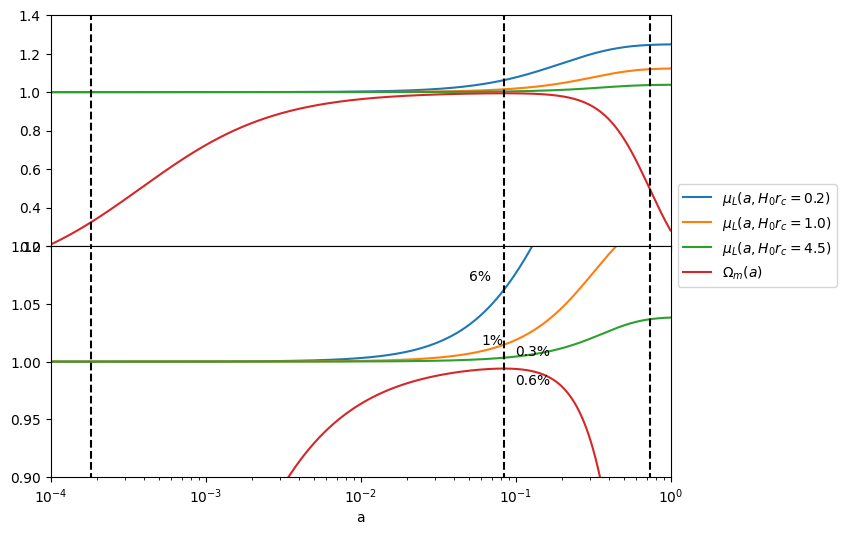

In [225]:
min_loga = -4
num = int(1e5)
H0rc_test = 0.2

a_test = np.logspace(min_loga, 0, num)

a_matterdom = a_test[np.argmax(cosmo_universe["Omega_m"]/a_test**3/E(cosmo_universe, a_test)**2)]

fig, ax = plt.subplots(2, figsize=(8,6), sharex =True)
fig.subplots_adjust(hspace=0,wspace=0)

ax[0].plot(a_test, mu_nDGP([H0rc_test,0,0,0], cosmo_universe, a_test))
ax[0].plot(a_test, mu_nDGP([1.0,0,0,0], cosmo_universe, a_test))
ax[0].plot(a_test, mu_nDGP([4.5,0,0,0], cosmo_universe, a_test))
ax[0].plot(a_test,cosmo_universe["Omega_m"]/a_test**3/E(cosmo_universe, a_test)**2)
ax[0].plot([(cosmo_universe["Omega_m"]/(1- cosmo_universe["Omega_m"]-cosmo_universe["Omega_g"]))**(1/3),(cosmo_universe["Omega_m"]/(1- cosmo_universe["Omega_m"]-cosmo_universe["Omega_g"]))**(1/3)] , [0,1.5], "k--")
ax[0].plot([(cosmo_universe["Omega_g"]/cosmo_universe["Omega_m"]),(cosmo_universe["Omega_g"]/cosmo_universe["Omega_m"])] , [0,1.5], "k--")
ax[0].plot([a_matterdom,a_matterdom] , [0,1.5], "k--")
ax[0].set_ylim(0.2,1.4)

ax[1].plot(a_test, mu_nDGP([H0rc_test,0,0,0], cosmo_universe, a_test), label=r"$\mu_L(a, H_0r_c ={})$".format(H0rc_test))
ax[1].plot(a_test, mu_nDGP([1.0,0,0,0], cosmo_universe, a_test), label=r"$\mu_L(a,H_0r_c =1.0)$")
ax[1].plot(a_test, mu_nDGP([4.5,0,0,0], cosmo_universe, a_test), label=r"$\mu_L(a,H_0r_c =4.5)$")

ax[1].plot(a_test,cosmo_universe["Omega_m"]/a_test**3/E(cosmo_universe, a_test)**2, label=r"$\Omega_m(a)$")

ax[1].plot([(cosmo_universe["Omega_m"]/(1- cosmo_universe["Omega_m"]-cosmo_universe["Omega_g"]))**(1/3),(cosmo_universe["Omega_m"]/(1- cosmo_universe["Omega_m"]-cosmo_universe["Omega_g"]))**(1/3)] , [0,1.5], "k--")

ax[1].plot([(cosmo_universe["Omega_g"]/cosmo_universe["Omega_m"]),(cosmo_universe["Omega_g"]/cosmo_universe["Omega_m"])] , [0,1.5], "k--")

ax[1].plot([a_matterdom,a_matterdom] , [0,1.5], "k--")

ax[1].set_xlabel("a")
ax[1].set_xscale("log")
ax[1].set_ylim(0.9,1.1)
ax[1].set_xlim(1e-4,1)
ax[1].legend(bbox_to_anchor=(1.0, 1.3))
#solverGrowth_nDGP
#solverGrowth_musigma

ax[1].text(5e-2,1.07,"{:.0f}%".format(round((mu_nDGP([H0rc_test,0,0,0], cosmo_universe, a_matterdom)-1)*100, 0)))
ax[1].text(6e-2,1.015,"{:.0f}%".format(round((mu_nDGP([1.0,0,0,0], cosmo_universe, a_matterdom)-1)*100, 0)))
ax[1].text(1e-1,1.005,"{:.1f}%".format(round((mu_nDGP([4.5,0,0,0], cosmo_universe, a_matterdom)-1)*100, 1)))

ax[1].text(1e-1,0.98,"{:.1f}%".format(round(((1-np.max(cosmo_universe["Omega_m"]/a_test**3/E(cosmo_universe, a_test)**2)))*100, 1)))




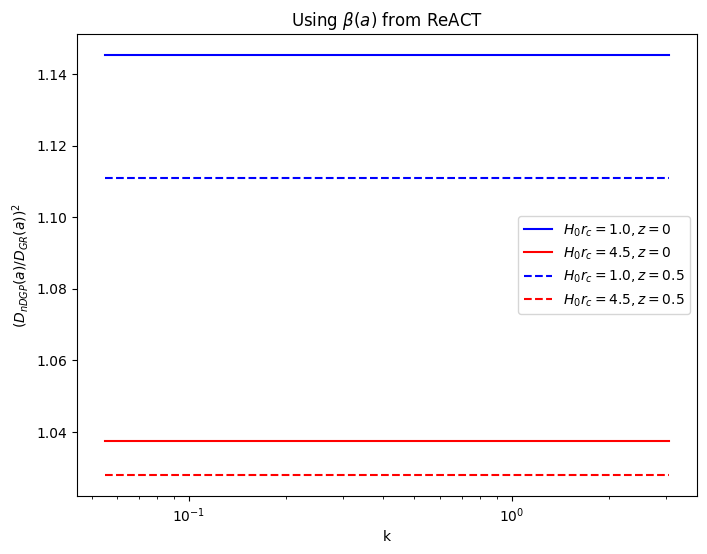

In [217]:
num = int(1e2)
H0rc_test = 0.2

k_test = np.logspace(np.log10(0.0156606)*cosmo_universe["h"], np.log10(4.99465)*cosmo_universe["h"], num)

#a_matterdom = a_test[np.argmax(cosmo_universe["Omega_m"]/a_test**3/E(cosmo_universe, a_test)**2)]

fig, ax = plt.subplots(1, figsize=(8,6))

#ax.plot(k_test, D_nDGP_D_GR([H0rc_test,0,0,0], cosmo_universe, a_test), label=r"$H_0r_c ={}$".format(H0rc_test))
ax.plot(k_test, np.ones(num)*D_nDGP_D_GR([1.0,0,0,0], cosmo_universe, 1)**2, "b",label=r"$H_0r_c =1.0, z = 0$")
ax.plot(k_test, np.ones(num)*D_nDGP_D_GR([4.5,0,0,0], cosmo_universe, 1)**2, "r",label=r"$H_0r_c =4.5, z = 0$")

ax.plot(k_test, np.ones(num)*D_nDGP_D_GR([1.0,0,0,0], cosmo_universe, 1/1.5)**2, "b--",label=r"$H_0r_c =1.0, z = 0.5$")
ax.plot(k_test, np.ones(num)*D_nDGP_D_GR([4.5,0,0,0], cosmo_universe, 1/1.5)**2, "r--",label=r"$H_0r_c =4.5, z = 0.5$")

ax.set_xlabel("k")
ax.set_xscale("log")
ax.set_title(r"Using $\beta(a)$ from BAO LP stability")
ax.set_ylabel(r"$(D_{nDGP}(a)/D_{GR}(a))^2$")
ax.legend()



Text(0, 0.5, 'P_NL/P_lin')

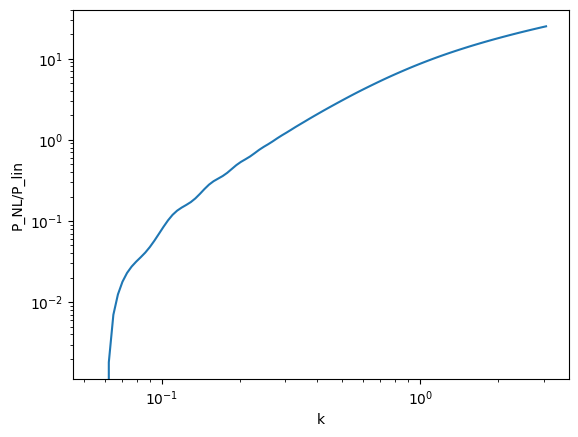

In [218]:
plt.plot(k_test,P_k_NL_nDGP(cosmo_universe, [1.0,0,0,0], k_test, 1)/P_k_nDGP_lin(cosmo_universe, [1.0,0,0,0], k_test, 1) - 1)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("k")
plt.ylabel("P_NL/P_lin")


In [219]:
"""Test nDP P(k)"""
"""Load ReACT pre-made plots"""
cosmo_testing = ccl.Cosmology(Omega_c = (0.1417493400784 - 0.0223)/0.67**2,
                           Omega_b =  0.0223/0.67**2,
                           h = 0.67,
                           n_s = 0.9665,
                           A_s = 2.01e-9)

# nDGP
arr = np.loadtxt("/home/c2042999/REACT_inst2/Lin_NL_nDGP_pk.txt")

# Cosmo and MG parameters same as in ReACT
Omegarc_arr = np.logspace(np.log10(0.2),np.log10(20)-0.001,12)

k_ReACT = arr[0][60:-10] * cosmo_testing["h"] # 1/Mpc
print(k_ReACT.shape)
pofk_lin_MG_react = arr[13:][:,60:-10] / cosmo_testing["h"]**3 # Mpc^3
print(pofk_lin_MG_react.shape)
pofk_NL_MG_react = arr[1:13][:,60:-10]  / cosmo_testing["h"]**3 # Mpc^3
print(pofk_NL_MG_react.shape)


(58,)
(12, 58)
(12, 58)


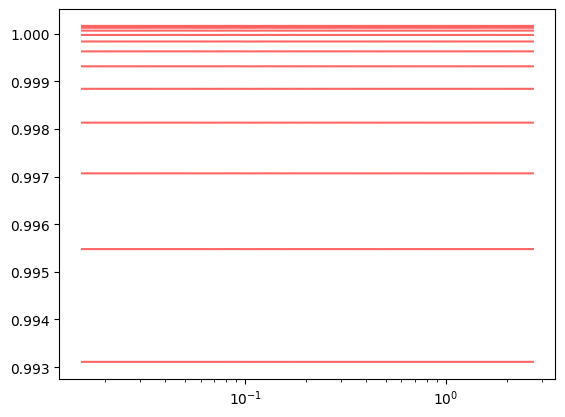

In [220]:
"""Test nDGP P(k)"""



for i in range(len(Omegarc_arr)):
    Pk_nDGP_lin_test = P_k_nDGP_lin(cosmo_testing, [Omegarc_arr[i],0,0,0], k_ReACT, 1)
    plt.semilogx(k_ReACT, (Pk_nDGP_lin_test) / (pofk_lin_MG_react[i]), "r", alpha=0.6)

In [210]:
"""Test nDGP with extended k,a"""
def pk_func(cosmo, MGParams, k, a):
        # condition on z
        if (1/a - 1) > 2:
            val = ccl.nonlin_matter_power(cosmo, k=k, a=a)
            return val
        else:
            idx_min = np.argmin(np.abs(k - 0.0156606*cosmo["h"])) + 1
            idx_max = np.argmin(np.abs(k - 4.99465*cosmo["h"])) -1
            k_allowed = k[idx_min:idx_max]
            pk = np.append(np.append(P_k_nDGP_lin(cosmo, MGParams, k[:idx_min], a),P_k_NL_nDGP(cosmo, MGParams, k_allowed, a)),
                           ccl.nonlin_matter_power(cosmo, k=k[idx_max:], a=a))
            return pk

In [29]:
idx_max = np.argmin(np.abs(k_test - 4.99465*cosmo_testing["h"])) - 1

pk_test = pk_func(cosmo_testing, [0.2,0,0,0], k_test, 1)
pk_test_lin = P_k_nDGP_lin(cosmo_testing, [0.2,0,0,0], k_test, 1)
pk_test1 = pk_func(cosmo_testing, [20,0,0,0], k_test, 1)
pk_test1_lin = P_k_nDGP_lin(cosmo_testing, [20,0,0,0], k_test, 1)


(100.0, 200000.0)

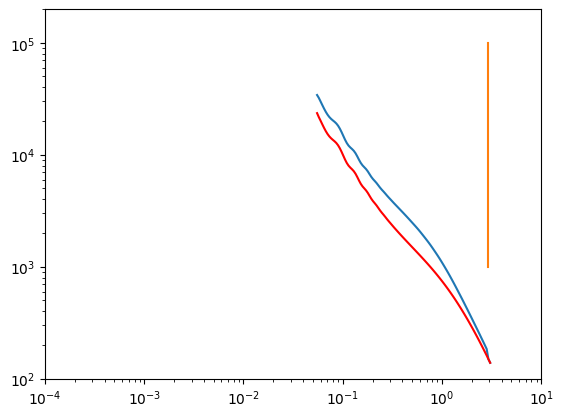

In [31]:
plt.loglog(k_test,pk_test)
#plt.loglog(k_test,pk_test_lin)
plt.loglog(k_test,pk_test1, "r")
#plt.loglog(k_test,pk_test1_lin, "r")
#plt.loglog(k_test,pk_GR_test_lin, "k--")
plt.loglog(k_test[idx_max]*np.array([1,1]), [1e3,1e5])
plt.xlim(1e-4,1e1)
plt.ylim(1e2,2e5)

In [ ]:
"""Test f(R) with extended k,a"""
print(np.max(forge_emulator.k)*cosmo_testing["h"], np.min(forge_emulator.k)*cosmo_testing["h"])
def pk_func(cosmo, MGParams, k, a):
        # condition on z
        if (1/a - 1) > 2:
            val = ccl.nonlin_matter_power(cosmo, k=k, a=a)
            return val
        else:
            idx_min = np.argmin(np.abs(k - np.min(forge_emulator.k)*cosmo["h"]))
            idx_max = np.argmin(np.abs(k - np.max(forge_emulator.k)*cosmo["h"]))
            k_allowed = k[idx_min:idx_max]
            pk = np.append(np.append(P_k_fR_lin(cosmo, MGParams, k[:idx_min], a),P_k_NL_fR(cosmo, MGParams, k_allowed, a)),
                           ccl.nonlin_matter_power(cosmo, k=k[idx_max:], a=a))
            return pk

In [53]:
idx_max = np.argmin(np.abs(k_test - np.max(forge_emulator.k)*cosmo_testing["h"]))

pk_test = pk_func(cosmo_testing, [0,1e-10,0,0], k_test, 1)
pk_test_lin = P_k_fR_lin(cosmo_testing, [0,1e-10,0,0], k_test, 1)
pk_test1 = pk_func(cosmo_testing, [0,1e-10,1,0], k_test, 1)
pk_test1_lin = P_k_fR_lin(cosmo_testing, [0,1e-10,0,0], k_test, 1)

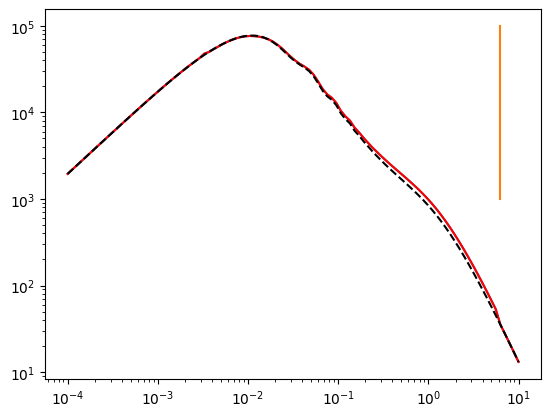

In [54]:
plt.loglog(k_test,pk_test)
#plt.loglog(k_test,pk_test_lin)
plt.loglog(k_test,pk_test1, "r")
#plt.loglog(k_test,pk_test1_lin, "r")
plt.loglog(k_test,pk_GR_test, "k--")
#plt.loglog(k_test,pk_GR_test_lin, "k--")
plt.loglog(k_test[idx_max]*np.array([1,1]), [1e3,1e5])